## 🚀 LaneFusion-CV  
A Hybrid Computer Vision + Deep Learning Framework for Autonomous Lane Detection

This notebook contains:
1) Classical Lane Detection (OpenCV)
2) Deep Learning Lane Segmentation (U-Net)
3) Real-time inference pipeline
4) Dataset loading from local directories

Dataset Paths (User Provided):
- Images:      C:/Users/pc/Desktop/LaneFusion-CV AI Project/road_line_images/road_line_images
- Annotations: C:/Users/pc/Desktop/LaneFusion-CV AI Project/road_line_annotation/road_line_annotation
"""


# 2️⃣ Imports & helper utilities 🧰
Statement: Load commonly-used imports and small helper functions for visualization and filesystem handling.

In [1]:
import cv2
print("OpenCV installed, version:", cv2.__version__)


OpenCV installed, version: 4.12.0


In [2]:
# ========================================================
# LaneFusion-CV: U-Net Training Import Necessary Libraries
# ========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# 3️⃣ Dataset exploration 🔎
Statement: Inspect dataset structure and view sample images. Adjust path if your download layout differs.

In [12]:
IMAGE_DIR = r"C:\Users\lenovo\Desktop\LaneFusion-CV AI Project\road_line_images\road_line_images"
MASK_DIR  = r"C:\Users\lenovo\Desktop\LaneFusion-CV AI Project\road_line_annotation\road_line_annotation"

image_files = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)])
mask_files  = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)])

print("Total Images:", len(image_files))
print("Total Masks :", len(mask_files))


Total Images: 50
Total Masks : 50


# 4️⃣ Preprocessing & augmentation ✨
Statement: Standard preprocessing used for both classical CV and DL: resize, normalization, and optional augmentation.

In [16]:
MASK_DIR = r"C:\Users\lenovo\Desktop\LaneFusion-CV AI Project\masks_png"

paired_images = []
paired_masks = []

for img_path in image_files:
    mask_name = os.path.basename(img_path).replace(".jpg", ".png")
    mask_path = os.path.join(MASK_DIR, mask_name)

    if os.path.exists(mask_path):
        paired_images.append(img_path)
        paired_masks.append(mask_path)

print("Filtered images:", len(paired_images))
print("Filtered masks :", len(paired_masks))


Filtered images: 48
Filtered masks : 48


In [17]:
IMG_SIZE = 256

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

X = np.array([load_image(p) for p in paired_images])
y = np.array([load_mask(p) for p in paired_masks])

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)

Train: (38, 256, 256, 3)
Val  : (10, 256, 256, 3)


# 🧠 5. Build U-Net Model

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 256

def unet_model():
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    bn = Conv2D(256, 3, activation='relu', padding='same')(p3)
    bn = Conv2D(256, 3, activation='relu', padding='same')(bn)

    # Decoder
    u3 = UpSampling2D()(bn)
    u3 = Concatenate()([u3, c3])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u2 = UpSampling2D()(c4)
    u2 = Concatenate()([u2, c2])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u1 = UpSampling2D()(c5)
    u1 = Concatenate()([u1, c1])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    outputs = Conv2D(1, 1, activation='sigmoid')(c6)

    return Model(inputs, outputs)


# 🎯 6. Train U-Net Model

In [19]:
model = unet_model()
model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=8)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5610 - loss: 0.6923 - val_accuracy: 0.9764 - val_loss: 0.6679
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9591 - loss: 0.6549 - val_accuracy: 0.9803 - val_loss: 0.6104
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9612 - loss: 0.5609 - val_accuracy: 0.9806 - val_loss: 0.3874
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9613 - loss: 0.2912 - val_accuracy: 0.9805 - val_loss: 0.1239
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9613 - loss: 0.2514 - val_accuracy: 0.9806 - val_loss: 0.1388
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9613 - loss: 0.1972 - val_accuracy: 0.9806 - val_loss: 0.1278
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9613 - loss: 0.1840 - val_accuracy: 0.9806 - val_loss: 0.1418
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9613 - loss: 0.1814 - val_accuracy: 0.9806 - val_loss: 0.1140
Epoch 9/20
5/5 

# 💾 7. Save Model

In [20]:
model.save("LaneFusionCV_UNET.h5")
print("Model Saved Successfully!")

Model Saved Successfully!


# 🔍 8. Classical Lane Detection (OpenCV Pipeline)

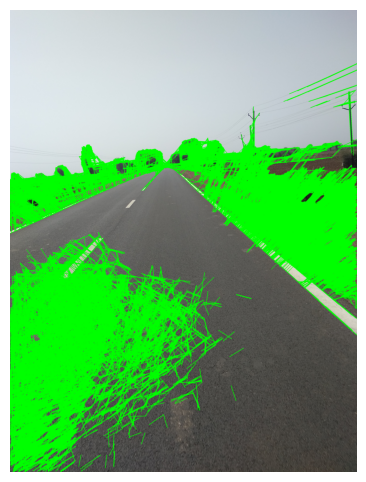

In [21]:
def classical_lane_detection(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=100, maxLineGap=50)
    if lines is not None:
        for x1,y1,x2,y2 in lines[:,0]:
            cv2.line(img, (x1,y1), (x2,y2), (0,255,0), 4)

    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

sample = paired_images[0]
classical_lane_detection(sample)


# 🧪 9. Deep Learning Inference on Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


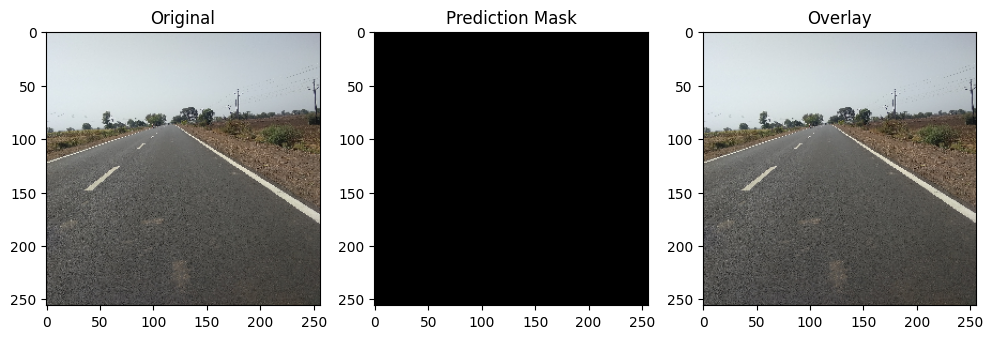

In [22]:
def predict_lane(img_path):
    img = load_image(img_path)
    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred = (pred > 0.5).astype(np.uint8)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Prediction Mask")
    plt.imshow(pred[:,:,0], cmap="gray")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    overlay = img.copy()
    overlay[:,:,1] += pred[:,:,0] * 255
    plt.imshow(overlay)

    plt.show()

# Test on a sample image
predict_lane(paired_images[0])


# 🎥 10. Video Lane Detection (Deep Learning)

In [23]:
def process_video(video_path, output_path="output_lane.mp4"):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (256, 256))

    while True:
        ret, frame = cap.read()
        if not ret: break
        
        frame_resized = cv2.resize(frame, (256,256))
        inp = frame_resized / 255.0
        
        pred = model.predict(np.expand_dims(inp, axis=0))[0]
        pred = (pred > 0.5).astype(np.uint8)

        overlay = frame_resized.copy()
        overlay[:,:,1] += pred[:,:,0] * 255
        
        out.write(overlay)

    cap.release()
    out.release()

# process_video("your_dashcam_video.mp4")
